In [ ]:
import random
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from feature_engine.creation import CyclicalTransformer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import RandomizedSearchCV

from catboost import CatBoostRegressor
from catboost import Pool
from xgboost import XGBRegressor

from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.impute import KNNImputer

In [3]:
DATA_PATH = 'data/data_after_preprocessing.csv'
END_DATE = '04/24/2022'

# Display all of the columns when data are shown
pd.set_option('display.max_columns', 60)

plt.rcParams['figure.figsize'] = (16, 8)
pd.options.mode.chained_assignment = None

In [4]:
data =  pd.read_csv(DATA_PATH, sep=',', parse_dates=['doc_date', 'product_since'], low_memory=False)

In [5]:
data

,bill_country,currency_id,basket_id,doc_date,exchange_currency_rate,basket_total_price_with_vat,count_basket_items,basket_count_products,basket_type,item_quantity,item_type,item_unit_price_with_vat,item_total_discount_with_vat,product_id,category_id,brand_id,product_status,reviews_count,reviews_average_score_price,reviews_average_score_quality,reviews_average_score_properties,reviews_average_score_overall,reviews_average_score,is_in_stock,is_ended,is_new,is_boosted,product_purchase_price,eshop_stock_count,is_fifo,product_since,category_status,segment_id,default_warranty_period,doc_day,doc_month,doc_year,doc_weekday,doc_week,days_in_shop,ancestor_count,descendant_count,cluster_hierar,kmeans_cluster
0,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,5.34,0.28,39848,179.0,145,1,83.0,95.192308,93.653846,93.653846,94.423077,94.277108,1,0,0,0,2.2050,-2.0,0,2019-01-22,1,1.0,24.0,26,4,2020,6,17,1188,3,1.0,2,91
1,1,1,1571607,2020-08-07,1.9558,319.00,11.0,13.0,1,1.0,1,5.62,0.00,39848,179.0,145,1,83.0,95.192308,93.653846,93.653846,94.423077,94.277108,1,0,0,0,2.2050,-2.0,0,2019-01-22,1,1.0,24.0,7,8,2020,4,32,1188,3,1.0,2,91
2,1,1,1661756,2020-08-29,1.9558,180.95,2.0,2.0,1,1.0,1,5.62,0.00,39848,179.0,145,1,83.0,95.192308,93.653846,93.653846,94.423077,94.277108,1,0,0,0,2.2050,-2.0,0,2019-01-22,1,1.0,24.0,29,8,2020,5,35,1188,3,1.0,2,91
3,1,1,1701910,2020-09-09,1.9558,127.31,2.0,2.0,1,1.0,1,5.62,0.00,39848,179.0,145,1,83.0,95.192308,93.653846,93.653846,94.423077,94.277108,1,0,0,0,2.2050,-2.0,0,2019-01-22,1,1.0,24.0,9,9,2020,2,37,1188,3,1.0,2,91
4,1,1,262709,2019-06-06,1.9558,240.57,8.0,28.0,1,3.0,1,5.11,0.00,39848,179.0,145,1,83.0,95.192308,93.653846,93.653846,94.423077,94.277108,1,0,0,0,2.2050,-2.0,0,2019-01-22,1,1.0,24.0,6,6,2019,3,23,1188,3,1.0,2,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713505,12,6,3375295,2021-08-16,1.0000,70.51,2.0,2.0,1,1.0,1,62.62,56.38,272147,2854.0,6755,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,0,0,29.7900,1.0,0,2021-05-04,1,6.0,24.0,16,8,2021,0,33,355,4,1.0,1,54
2713506,3,6,3057913,2022-02-03,1.0000,57.30,3.0,3.0,1,1.0,1,28.90,0.00,301637,1296.0,6481,1,1.0,0.000000,0.000000,0.000000,0.000000,100.000000,1,0,0,0,12.6300,1.0,0,2021-11-16,1,3.0,24.0,3,2,2022,3,5,159,2,1.0,1,41
2713507,9,6,3325485,2021-08-04,1.0000,329.00,1.0,1.0,3,1.0,1,329.00,0.00,274590,1304.0,6772,3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,175.3200,0.0,0,2021-05-25,1,3.0,24.0,4,8,2021,2,31,334,2,1.0,3,54
2713508,11,9,1728853,2020-09-17,7.5415,260.96,14.0,14.0,1,1.0,1,16.84,0.00,191250,2042.0,2799,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,0,10.9475,4.0,0,2019-12-06,1,16.0,24.0,17,9,2020,3,38,870,1,1.0,1,0


We want to make predictions weekly, as there are data with too little density for good daily prediction. Also we don't need to predict every single day, every week is fully enough.

In [ ]:
days_together = data[['product_id', 'days_in_shop']].drop_duplicates().days_in_shop.sum()
all_sales_amount = len(data.index)
print(f'Non-zero values would be in {round(all_sales_amount / days_together, 5)*100}% of days')

# Prepare data

## Drop unsettable columns
We want to predict, how many items of given type we will sell. That means - the predicted column will be 'item_quantity'. We don't know, how many items will be in basket, it's type etc. \
We only know values of columns we can influence (or which are already written) - for example price of the product, or it's brand. \
These columns were great for clustering products, as they can show some patterns in them, but for pure pretictions we are dropping those data.

In [6]:
data = data.drop(labels=['basket_id', 'basket_total_price_with_vat', 'basket_count_products', 'basket_type', 'count_basket_items', 'bill_country', 'currency_id', 'exchange_currency_rate', 'is_in_stock', 'eshop_stock_count'], axis=1)

After using Variance Threshold selection to find the columns with small variance we've found that LOW_VARIANCE_COLUMNS are viable for dropping as they are not good features for models. \
Code for finding such columns is provided and commented, but it is not desired to be a part of every program run, as this calculation takes some time. \
If use desires though, they can test the code, as written, on multiple clusters and find if the LOW_VARIANCE_COLUMNS list is still accurate. \
Those columns are dropped at this place though, so if such tests are desired it is necessary to remove the row 'data.drop(labels=LOW_VARIANCE_COLUMNS, axis=1)'.

In [7]:
## Drop columns that have too small variance to influence models 
# sel = VarianceThreshold(threshold=(0.16))
# sel.fit_transform(selected_cluster)
# to_drop = list(set(selected_cluster.columns) - set(sel.get_feature_names_out(selected_cluster.columns)))

LOW_VARIANCE_COLUMNS = ['descendant_count',
 'item_type',
 'is_ended',
 'is_fifo',
 'category_status',
 'is_new',
 'is_boosted']

data = data.drop(labels=LOW_VARIANCE_COLUMNS, axis=1)

In [8]:
def encode_values(df : pd.DataFrame) -> pd.DataFrame:
    """
    Transform columns by transformer suitable for them.
    Params
        df -> DataFrame containing columns for transformation
    Returns
        DataFrame -> DataFrame with values normalized by different techniques
    """

    # Cyclical transformation of date variables
    cyclical = CyclicalTransformer(variables=['week', 'month'], drop_original=True)
    df = cyclical.fit_transform(df)
    
    
    # Normalization for some variables is the best solution
    df['year'] = df['year'] / max(df['year'])

    
    # Use min max scaling for remaining columns
    scaler = MinMaxScaler()
    scaled_columns =['item_unit_price_with_vat', 'product_purchase_price', 'item_total_discount_with_vat', 'product_id', 'category_id', 'brand_id', 'segment_id', 'reviews_count',
                     'reviews_average_score_price', 'reviews_average_score_quality', 'reviews_average_score_properties', 'reviews_average_score_overall', 'reviews_average_score',
                     'product_status', 'ancestor_count', 'days_in_shop']
    
    
    
    scaled = scaler.fit_transform(df[scaled_columns])
    scaled = pd.DataFrame(scaled, columns = scaled_columns)
    
    for col in scaled_columns:
        df[col] = scaled[col].values
    
    return df

In [9]:
def missing_values_replace_knn(df : pd.DataFrame) -> pd.DataFrame:
        """
        Function for computing new values from dataframe using kNN. 
        Params
            df -> DataFrame of sales with NaN values as well.
        Returns 
            Original Dataframe with replaced NaNs.
        """
        
        knn = KNNImputer()
        knn_trans = knn.fit_transform(df)
        return pd.DataFrame(knn_trans, columns = df.columns)


In [10]:
def fill_zeroes_weekly(df: pd.DataFrame) -> pd.DataFrame: 
    """
    Function that takes DataFrame of sales and also fills weeks, where 0 products were sold. It also adds feature of last N weeks sold to DataFrame, as usefull features
    Params
        df -> DataFrame containing orders informations
    Returns
        DataFrame -> DataFrame containing weeks with 0 sales as well
    """
    date_columns = 'doc_date'
    desired_cols = ['year', 'week', 'month', 'quantity_sold', 'item_unit_price_with_vat',
       'product_purchase_price', 'item_total_discount_with_vat', 'product_id',
       'category_id', 'brand_id', 'segment_id', 'reviews_count',
       'reviews_average_score_price', 'reviews_average_score_quality',
       'reviews_average_score_properties', 'reviews_average_score_overall',
       'reviews_average_score', 'product_status',
        'ancestor_count',
       'days_in_shop']
    
    
    try:
        dates = pd.date_range(start=df.product_since.iloc[0], end=END_DATE)
        weekly_sales = dates.isocalendar()[['year', 'week']]
        weekly_sales['month'] = dates.month
        weekly_sales = weekly_sales.drop_duplicates()
    except:
        # If there is no sale of given product
        return pd.DataFrame(columns=desired_cols)

    
    sales, shop_days, item_price, item_discount, item_purchase_price = [], [], [], [], []
    for wk in weekly_sales.iterrows():
        if len(df[df.doc_week.__eq__(wk[1].week) & df.doc_month.__eq__(wk[1].month) & df.doc_year.__eq__(wk[1].year)].index) > 0:
            sales.append(df[df.doc_week.__eq__(wk[1].week) & df.doc_month.__eq__(wk[1].month) & df.doc_year.__eq__(wk[1].year)].item_quantity.sum())
            
            item_price.append(df[df.doc_week.__eq__(wk[1].week) & df.doc_month.__eq__(wk[1].month) & df.doc_year.__eq__(wk[1].year)].item_unit_price_with_vat.mean())
            item_purchase_price.append(df[df.doc_week.__eq__(wk[1].week) & df.doc_month.__eq__(wk[1].month) & df.doc_year.__eq__(wk[1].year)].product_purchase_price.mean())
            item_discount.append(df[df.doc_week.__eq__(wk[1].week) & df.doc_month.__eq__(wk[1].month) & df.doc_year.__eq__(wk[1].year)].item_total_discount_with_vat.mean())
            
        else:
            sales.append(0)
            item_price.append(None)
            item_purchase_price.append(None)
            item_discount.append(None)
        
        shop_days.append((wk[0] - df.product_since.iloc[0]).days)
    

    weekly_sales['quantity_sold'] = sales
    weekly_sales['item_unit_price_with_vat'] = item_price
    weekly_sales['product_purchase_price'] = item_purchase_price
    weekly_sales['item_total_discount_with_vat'] = item_discount
    weekly_sales[['product_id', 'category_id', 'brand_id', 'segment_id']] = df.product_id.iloc[0], int(df.category_id.iloc[0]), df.brand_id.iloc[0], df.segment_id.iloc[0]
    weekly_sales[['reviews_count', 'reviews_average_score_price', 'reviews_average_score_quality', 'reviews_average_score_properties', 'reviews_average_score_overall', 'reviews_average_score']] = \
    df.reviews_count.iloc[0], df.reviews_average_score_price.iloc[0], df.reviews_average_score_quality.iloc[0], df.reviews_average_score_properties.iloc[0], df.reviews_average_score_overall.iloc[0], df.reviews_average_score.iloc[0]
    weekly_sales[['product_status', 'ancestor_count']] = df.product_status.iloc[0], df.ancestor_count.iloc[0]
    weekly_sales['days_in_shop'] = shop_days
       
 
    try:
        weekly_sales = missing_values_replace_knn(weekly_sales)
    except:
        return pd.DataFrame(columns=desired_cols)
    
    
    PAST_WINDOW_SIZE = 7
    for previous in range (1, PAST_WINDOW_SIZE + 1):
        past_values = weekly_sales['quantity_sold']
        weekly_sales[f'sold_{previous}_weeks_ago'] = past_values.shift(previous)

    
    weekly_sales
    return weekly_sales

In [11]:
def group_week(df : pd.DataFrame) -> pd.DataFrame:
    """
    We want to have data of product sales based on weekly sales, for that we need to squish our data into weekly ones.
    Params
        df -> DataFrame containing data of sales
    Return
        DataFrame -> DataFrame where sales are groupped by week sales rather than daily
    """
    
    df = df.drop(labels=['doc_weekday', 'doc_day'], axis=1)

    df = df.groupby(by=['product_id', 'doc_year', 'doc_month', 'doc_week'], as_index=False).agg({'item_quantity' : 'sum', \
                                                                                                   #  'item_type' : 'first', \
                                                                                                      'item_unit_price_with_vat' : 'mean', \
                                                                                                      'item_total_discount_with_vat' : 'mean', \
                                                                                                      'product_id' : 'first', \
                                                                                                      'category_id' : 'first', \
                                                                                                      'brand_id' : 'first', \
                                                                                                      'product_status' : 'first', \
                                                                                                      'reviews_count' : 'first', \
                                                                                                      'reviews_average_score_price' : 'first', \
                                                                                                      'reviews_average_score_quality' : 'first', \
                                                                                                      'reviews_average_score_properties' : 'first', \
                                                                                                      'reviews_average_score_overall' : 'first', \
                                                                                                      'reviews_average_score' : 'first', \
                                                                                                   #   'is_ended' : 'first', \
                                                                                                   #   'is_new' : 'first', \
                                                                                                   #   'is_boosted' : 'first', \
                                                                                                      'product_purchase_price' : 'mean', \
                                                                                                   #   'is_fifo' : 'first', \
                                                                                                   #   'category_status' : 'first', \
                                                                                                      'segment_id' : 'first', \
                                                                                                      'default_warranty_period' : 'first', \
                                                                                                      'days_in_shop' : 'first', \
                                                                                                      'ancestor_count' : 'first', \
                                                                                                   #   'descendant_count' : 'first', \
                                                                                                      'product_since' : 'first'                  
                                                                                                      }) 

    
    weekly_sales = pd.DataFrame()
    for prod in df.product_id.unique():
        weekly_sales = pd.concat([weekly_sales, fill_zeroes_weekly(df[df.product_id.__eq__(prod)])])

    weekly_sales = weekly_sales.apply(pd.to_numeric)
    
    return weekly_sales

In [77]:
def prepare_cluster_split_data(df: pd.DataFrame, hierarchical_cluster : id, kmeans_cluster : id) -> tuple:
    """
    Function that cleanse, prepares and returns data of weekly sales in given cluster
    Params
        df - dataframe containing required data
        hierarchical cluster - hierarchical cluster number, usually from <1, 3> interval
        kmeans cluster - cluster decicded by kmeans clustering, usually from <1, 101> interval
    Returns
        tuple - tuple containing prepared (normalized) and split data in order (X_train, y_train, X_test, y_test)
    """
    
    selected_cluster = data[data.cluster_hierar.__eq__(hierarchical_cluster) & data.kmeans_cluster.__eq__(kmeans_cluster)]
    
    # Drop clusters as they are the same for each product of given cluster
    selected_cluster = selected_cluster.drop(labels=['cluster_hierar', 'kmeans_cluster'], axis=1)
    
    
    # Next we need to rework data to weekkly sales rather than daily 
    selected_cluster = group_week(selected_cluster)

    # Split data set into test, train and to X, y
    train = selected_cluster[selected_cluster.year < 2022]
    test = selected_cluster[selected_cluster.year == 2022]
    
    X_train = train.drop(labels=['quantity_sold'], axis=1)
    y_train = train[['quantity_sold']]

    X_test = test.drop(labels=['quantity_sold'], axis=1)
    y_test = test[['quantity_sold']]
    
    # Encode values for models
    X_train = encode_values(X_train)
    X_test = encode_values(X_test)

    return (X_train, y_train, X_test, y_test)

In [78]:
def feature_importance_xgb(df : pd.DataFrame, TEST_SIZE : int = 30, model : XGBRegressor = None) -> pd.DataFrame:
    """
    Let's check the importance of remaining features based on TEST_SIZE random cluster predictions.
    Params
        df -> DataFrame containing information about product sales.
        TEST_SIZE -> Default 30 
    """
    tested = [[]]
    xgb_feature_importance = []
    
    for check in range (TEST_SIZE):
        
        test_cluster = []
        while test_cluster in tested:
            test_cluster = [random.randint(1, 101), random.randint(1, 3)] 
        
        tested.append(test_cluster)

        X_train, y_train, X_test, y_test = prepare_cluster_split_data(df, test_cluster[1], test_cluster[0])

        if model is None:
            model = XGBRegressor(learning_rate = 0.05, n_estimators=250,
                           max_depth=4, min_child_weight=1,
                           gamma=0, subsample=0.8, reg_lambda=10,       
                           early_metric='auc',
                           eval_set=[(X_test, y_test)],
                           colsample_bytree=0.8, objective= "reg:squarederror",  
                           nthread=-1,scale_pos_weight=1, seed=27,
                          importance_type='total_gain')
        
        
        model.fit(X_train, y_train)

        if check == 0:
            xgb_feature_importance = xgb.feature_importances_
        else:
            xgb_feature_importance += xgb.feature_importances_
            
        print(f'Done {check+1} out of {TEST_SIZE} models. ({(1+check)*100/TEST_SIZE}%)')
    
    return(xgb.get_booster().feature_names, xgb_feature_importance / TEST_SIZE)

In [79]:
names, values = feature_importance_xgb(data, 5, xgb)
importances = [{name: value} for (name, value) in zip(names, values)]
print('\nImportance of parameters:')
print(importances)

Done 1 out of 5 models. (20.0%)
Done 2 out of 5 models. (40.0%)


KeyboardInterrupt: 

In [14]:
X_train, y_train, X_test, y_test = prepare_cluster_split_data(data, 1, 1)

In [35]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data,model, param_grid, cv=10, scoring_fit='neg_mean_squared_error', do_probabilities = False, n_iterations = 10):
        rs = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid, 
            cv=cv, 
            n_jobs=1, 
            n_iter=n_iterations,
            scoring=scoring_fit,
            verbose=10
        )
        fitted_model = rs.fit(X_train_data, y_train_data)

        if do_probabilities:
            pred = fitted_model.predict_proba(X_test_data)
        else:
            pred = fitted_model.predict(X_test_data)

        return fitted_model, pred

In [23]:
parameters = { 
    'booster' : ['gbtree', 'gblinear'], 
    'verbosity' : [0],
    'eta' : [0.01, 0.05, 0.1, 0.2, 0.3, 0.6, 1],   # learning rate
    'n_estimators': [250, 400, 700, 1000],
    'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
    'max_depth': [3, 5, 7, 10, 15],
    'reg_alpha': [0, 0.5 , 1, 1.1, 1.3],
    'reg_lambda': [0.5, 1, 1.1, 1.3],
    'subsample': [0.4, 0.6, 0.7, 0.8, 0.9, 1],
    'min_child_weight': [1, 5, 10, 15],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'objective': ['reg:squarederror', 'reg:squaredlogerror'],
    'seed': [29, 49],
}

In [36]:
start = time.time()

xgb_r = XGBRegressor()
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, xgb_r, parameters, cv=2, n_iterations=50)

end = time.time()

print(f"{(end-start)/60} minutes.")

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV 1/2; 1/50] START booster=gbtree, colsample_bytree=1.0, eta=0.01, gamma=1.5, max_depth=3, min_child_weight=10, n_estimators=400, objective=reg:squaredlogerror, reg_alpha=1.3, reg_lambda=1.1, seed=49, subsample=0.6, verbosity=0
[CV 1/2; 1/50] END booster=gbtree, colsample_bytree=1.0, eta=0.01, gamma=1.5, max_depth=3, min_child_weight=10, n_estimators=400, objective=reg:squaredlogerror, reg_alpha=1.3, reg_lambda=1.1, seed=49, subsample=0.6, verbosity=0;, score=-0.338 total time=  11.9s
[CV 2/2; 1/50] START booster=gbtree, colsample_bytree=1.0, eta=0.01, gamma=1.5, max_depth=3, min_child_weight=10, n_estimators=400, objective=reg:squaredlogerror, reg_alpha=1.3, reg_lambda=1.1, seed=49, subsample=0.6, verbosity=0
[CV 2/2; 1/50] END booster=gbtree, colsample_bytree=1.0, eta=0.01, gamma=1.5, max_depth=3, min_child_weight=10, n_estimators=400, objective=reg:squaredlogerror, reg_alpha=1.3, reg_lambda=1.1, seed=49, subsample=0.6, 

In [39]:
print(np.sqrt(-model.best_score_))
print(model.best_params_)

0.6395916845486782
{'verbosity': 0, 'subsample': 0.6, 'seed': 49, 'reg_lambda': 1.1, 'reg_alpha': 1.3, 'objective': 'reg:squaredlogerror', 'n_estimators': 400, 'min_child_weight': 10, 'max_depth': 3, 'gamma': 1.5, 'eta': 0.01, 'colsample_bytree': 1.0, 'booster': 'gbtree'}


In [40]:
model.best_params_

{'verbosity': 0,
 'subsample': 0.6,
 'seed': 49,
 'reg_lambda': 1.1,
 'reg_alpha': 1.3,
 'objective': 'reg:squaredlogerror',
 'n_estimators': 400,
 'min_child_weight': 10,
 'max_depth': 3,
 'gamma': 1.5,
 'eta': 0.01,
 'colsample_bytree': 1.0,
 'booster': 'gbtree'}

In [53]:
model.best_params_

{'verbosity': 0,
 'subsample': 0.6,
 'seed': 49,
 'reg_lambda': 1.1,
 'reg_alpha': 1.3,
 'objective': 'reg:squaredlogerror',
 'n_estimators': 400,
 'min_child_weight': 10,
 'max_depth': 3,
 'gamma': 1.5,
 'eta': 0.01,
 'colsample_bytree': 1.0,
 'booster': 'gbtree'}

In [58]:
xgb = XGBRegressor(verbosity=0,
                  subsample=0.6,
                  seed=49,
                  reg_lambda=1.1,
                  reg_alpha=1.3,
                  objective="reg:squaredlogerror",
                  n_estimators=400,
                  min_child_weight=10,
                  max_depth=3,
                  gamma=1.5,
                  eta=0.01,
                  colsample_bytree=1.0,
                  booster='gbtree')


In [698]:
xgb = XGBRegressor(learning_rate = 0.05, n_estimators=250, booster='gbtree', verbosity=0,
                           max_depth=4, min_child_weight=10,
                           gamma=0, subsample=0.8, reg_lambda=10,            
                           colsample_bytree=0.8, objective= "reg:squarederror",  
                           nthread=-1,scale_pos_weight=1, seed=27,
                          importance_type='total_gain')

In [59]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False, eta=0.01,
             eval_metric=None, gamma=1.5, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.00999999978, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=10,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, objective='reg:squaredlogerror',
             predictor='auto', random_state=49, ...)

In [60]:
predicted = xgb.predict(X_train)
predicted_test = xgb.predict(X_test)

In [ ]:
print(median_absolute_error(y_train.quantity_sold.values, predicted))
print(median_absolute_error(y_test.quantity_sold.values, predicted_test))

print('\n')

print(mean_absolute_error(y_train.quantity_sold.values, predicted))
print(mean_absolute_error(y_test.quantity_sold.values, predicted_test))

print('\n')

print(f1_score(y_train.quantity_sold.values, predicted.round(), average='weighted'))
print(f1_score(y_test.quantity_sold.values, predicted_test.round(), average='weighted'))

print('\n')

print(recall_score(y_train.quantity_sold.values, predicted.round(), average='weighted', zero_division=1))
print(recall_score(y_test.quantity_sold.values, predicted_test.round(), average='weighted', zero_division=1))

print('\n')

print(precision_score(y_train.quantity_sold.values, predicted.round(), average='weighted', zero_division=1))
print(precision_score(y_test.quantity_sold.values, predicted_test.round(), average='weighted', zero_division=1))

In [68]:
train_predicted = pd.DataFrame({'relative_dates' : relative_dates, 'values' : predicted}).groupby('relative_dates').sum().dropna()
test_predicted = pd.DataFrame({'relative_dates' : relative_dates_test, 'values' : predicted_test}).groupby('relative_dates').sum().dropna()
train_real = pd.DataFrame({'relative_dates' : relative_dates, 'values' : y_train.quantity_sold}).groupby('relative_dates').sum().dropna()
test_real = pd.DataFrame({'relative_dates' : relative_dates_test, 'values' : y_test.quantity_sold}).groupby('relative_dates').sum().dropna()

plt.plot(train_predicted.append(test_predicted))
plt.plot(train_real.append(test_real))
plt.plot()

NameError: name 'relative_dates' is not defined

[]

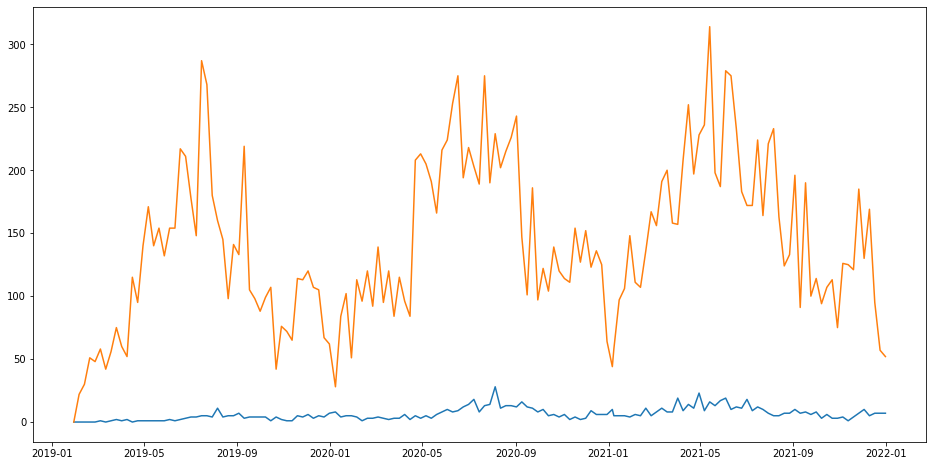

In [73]:
plt.plot(pd.DataFrame({'relative_dates' : relative_dates, 'values' : predicted}).groupby('relative_dates').sum().dropna())
plt.plot(pd.DataFrame({'relative_dates' : relative_dates, 'values' : y_train.quantity_sold}).groupby('relative_dates').sum().dropna())
plt.plot()

[]

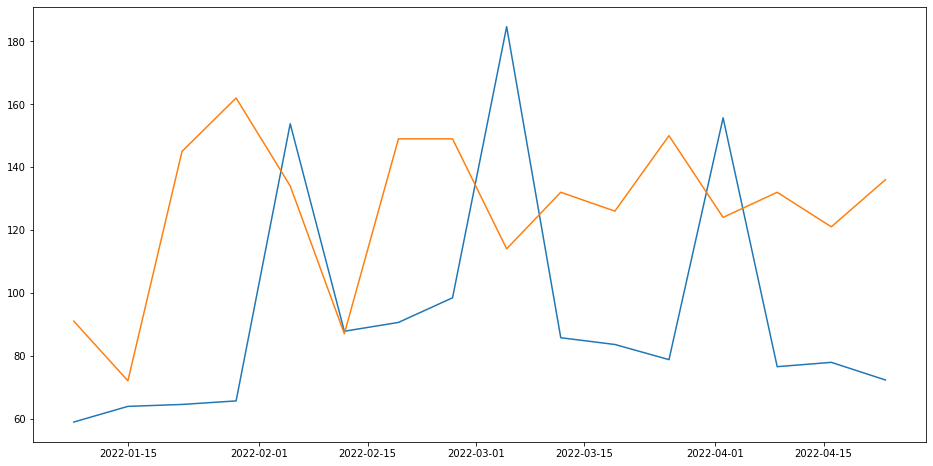

In [75]:
plt.plot(pd.DataFrame({'relative_dates' : relative_dates_test, 'values' : predicted_test}).groupby('relative_dates').sum().dropna())
plt.plot(pd.DataFrame({'relative_dates' : relative_dates_test, 'values' : y_test.quantity_sold}).groupby('relative_dates').sum().dropna())
plt.plot()

In [ ]:
plt.plot(pd.DataFrame({'relative_dates' : relative_dates_test, 'values' : predicted_test}).groupby('relative_dates').sum().dropna())
plt.plot(pd.DataFrame({'relative_dates' : relative_dates_test, 'values' : y_test.quantity_sold}).groupby('relative_dates').sum().dropna())
plt.plot()

In [70]:
from datetime import date
from dateutil.relativedelta import relativedelta

relative_dates = [date(int(train.iloc[i].year), 1, 1) + relativedelta(weeks =+ train.iloc[i].week) for i in range(len(train.index))]
relative_dates_test = [date(int(test.iloc[i].year), 1, 1) + relativedelta(weeks =+ test.iloc[i].week) for i in range(len(test.index))]

In [ ]:
ctb = CatBoostRegressor()

prd = ctb.predict(X_train)
prd_t = ctb.predict(X_test)

print(median_absolute_error(y_train.quantity_sold, prd))
print(median_absolute_error(y_test.quantity_sold, prd_t))

print('\n')

print(mean_absolute_error(y_train.quantity_sold, prd))
print(mean_absolute_error(y_test.quantity_sold, prd_t))

In [ ]:
model = CatBoostRegressor(
    iterations=1000, 
    learning_rate=0.02, 
    max_depth=5,
    l2_leaf_reg=10, 
    loss_function='RMSE',
    random_seed=1,
    od_type='Iter',
    od_wait=25,
    verbose=100,
    use_best_model=False
    )

model.fit(X_train, y_train,
              early_stopping_rounds=3000,
              verbose=100)

In [ ]:
MSE = np.square(predicted.round(), y_train['quantity_sold']).mean()
RMSE = math.sqrt(MSE)
RMSE

In [ ]:
def evaluate_dataset(real_values, predicted_values, *print_results):
    # Function takes two arrays - real values and predicted values by any method.
    # From that it uses sklearn methods to compute accuracy, precision and recall of prediction
    # It also allows boolean print_results - default True, if False then doesn't print metrics result
    
    if(len(print_results)) == 0:
        print_results = True
    else:
        print_results = print_results[0]
    
    # Average in precision and recall can be changed to 'weighted’, 'micro', 
    # ‘macro’, ‘samples’, ‘binary’ or None for more results.
    # It calculates average (or doesn't when None) from all predictions 
    # Select None if you want to see score for each class (for 0 and 1 predictions)
    precision =  {precision_score(real_values, predicted_values, average='macro')}
    recall = {recall_score(real_values, predicted_values, average='macro')}
    accuracy = {accuracy_score(real_values, predicted_values, normalize=True)}
    
    if print_results:
        print(f"Precision: {precision}")
        print(f"Recall   : {recall}")
        print(f"Accuracy : {accuracy}\n")
    
    # Return accuracy as number to draw overfitting graphs
    return accuracy.pop()  

# IDEAS

## LSTMS

In [ ]:
X_train.shape

y_train.shape

n_input = 25                 # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32                  # Number of timeseries samples in each batch
generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)

print(generator[0][0].shape)



model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

#model.fit(generator,epochs=5)




lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='relu')
])

lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
lstm.build()
lstm.summary()

In [ ]:
"""
TODO 
OPIS TRANSOFMEROV MinMax a Cyclical
OPIS A UPRATANIE CLUSTERINGU


TODO 
preorbit kolacove grafy na boxploty, bar
"""

"""
IDEAS
PRIDAJ ROZBITIE NA TRENDY DO Samotneho vyhodnocovania
NAPOCITANIE PREDAJOV PRODUKTOV ZA TYZDEN????


NEDAVAJ PIE GRAFY DO PRACE!!!!
IMPROVEMENT PRICE CHANGE TRACKING - TRACKING OTHER ARGUMENTS AS WELL (ESHOP STOCK COUNT, VISITS, ...)
GROUPING ALL INTERNATIONAL SALES
"""